# Imports

In [2]:
# %matplotlib qt
# %matplotlib qt
import numpy as np
import matplotlib.pyplot as plt
import cv2
import h5py
from scipy import ndimage
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.manifold import TSNE
from skimage.color import lab2rgb , rgb2lab
from skimage import feature
from skimage import filters

import scipy.fftpack
import scipy.signal as signal

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.cluster import KMeans

import copy
import time

from openTSNE import TSNE as opTSNE

from sklearn.mixture import GaussianMixture 
# from lifelines import KaplanMeierFitter
from scipy.stats import multivariate_normal
import imageio
from functools import reduce
import copy
import time

from openTSNE import TSNE as opTSNE

# Functions

In [3]:
def SampleZoomIn(SampleID , PixelSampleID ,padding_factor = 1):
    specific_index = SampleID
    mask = (PixelSampleID == specific_index) 
    label_indices = np.where(mask == True)

    zoomed_height_max = max(label_indices[0]) + padding_factor
    zoomed_height_min = min(label_indices[0]) - padding_factor
    zoomed_width_max = max(label_indices[1]) + padding_factor
    zoomed_width_min = min(label_indices[1]) - padding_factor

    if zoomed_height_max > height:
        zoomed_height_max= height

    if zoomed_height_min < 0:
        zoomed_height_min= 0

    if zoomed_width_max > width:
        zoomed_width_max= width

    if zoomed_width_min < 0:
        zoomed_width_min= 0
        
    return zoomed_height_max , zoomed_height_min , zoomed_width_max, zoomed_width_min

In [4]:
def rescale(arr):
    arr_min = arr.min()
    arr_max = arr.max()
    return (arr - arr_min) / (arr_max - arr_min)
def rescale_AB(arr):
    arr_min = arr.min()
    arr_max = arr.max()
    return ( (arr - arr_min) / (arr_max - arr_min)  ) * 255 - 128

In [5]:
# def CreateColorMap(NumberofColors , colorsArray ):
#     cvals = np.arange(0,NumberofColors-1)
#     colors = colorsArray
#     norm=plt.Normalize(min(cvals),max(cvals))
#     tuples = list(zip(map(norm,cvals), colors))
#     cmap = LinearSegmentedColormap.from_list("", tuples)

#     base = plt.cm.get_cmap(cmap)
#     color_list = base(np.linspace(0, 1, NumberofColors))
#     cmap_name = base.name + str(NumberofColors)
#     cmap = base.from_list(cmap_name, color_list, NumberofColors)
#     return cmap

In [5]:
from matplotlib.colors import LinearSegmentedColormap
def CreateColorMap(NumberofColors , colorsArray ):
    cmap = LinearSegmentedColormap.from_list('cmap', colorsArray, N=NumberofColors)
    return cmap

# Reading Breast Data

In [6]:
h5 = h5py.File('breastData.mat', 'r')


HE_image= h5.get('HE_image')[:]
HE_image = HE_image.swapaxes(0,2)


MSI_data_cube= h5.get('MSI_data_cube')[:]
MSI_data_cube = MSI_data_cube.swapaxes(0,2)

goodlist= h5.get('goodlist')[:]
goodlist = goodlist.swapaxes(0,1)

peak_list= h5.get('peak_list')[:]
peak_list = peak_list.swapaxes(0,1)

pixel_to_sample_ID= h5.get('pixel_to_sample_ID')[:]
pixel_to_sample_ID = pixel_to_sample_ID.swapaxes(0,1)  

h5.close()

# Clinical_data = pd.read_excel('ClinicalData.xlsx')
height , width = (pixel_to_sample_ID.shape) # ( 443 , 1653 )

flattened_MSI_data_cube = MSI_data_cube.flatten().reshape(MSI_data_cube.shape[0] * MSI_data_cube.shape[1] , MSI_data_cube.shape[2])

flattened_pixel_to_sample_ID = pixel_to_sample_ID.flatten() 
indices_of_background = np.where(flattened_pixel_to_sample_ID == -1)
sample_only_data = np.delete(flattened_MSI_data_cube, indices_of_background[0] , axis=0)
sample_ID_pixels = np.delete(flattened_pixel_to_sample_ID , indices_of_background[0] , axis=0)
# The scaler object (model)
scaler = StandardScaler()
# fit and transform the data
sample_only_scaled_data = scaler.fit_transform(sample_only_data) 

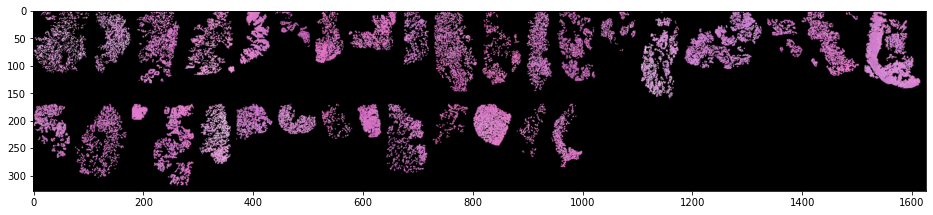

In [8]:
plt.figure(figsize=(16,10))
plt.imshow(HE_image)
plt.show()

In [20]:
# colorsarray = [ "black" , "royalblue" , , "aqua" , "orangered" , "yellow",,"sandybrown","red" ] 
# colorsarray=["black","#80B1D3","#FF7F0E","#2CA02C","#B5CF6B","#9467BD","#E7CB94","#BCBD22","#FFD92F"]
# colorsarray=['#000000','powderblue','magenta', 'teal', 'yellow', 'blue', 'orange',"lime","crimson"]
colorsarray8 = [ "black" , "magenta" , "#007fff", "#00ffff" , "#7fff7f" , "#ffff00","#ff7f00","#ff0000","#7f0000" ]
colorsarray7 = [ "black" , "magenta" , "#007fff", "#00ffff" , "#7fff7f" , "#ffff00","#ff7f00","#ff0000" ]
colorsarray6 = [ "black" , "magenta" , "#007fff", "#00ffff" , "#7fff7f" , "#ffff00","#ff7f00" ]
colorsarrayTSNE = ["magenta" , "#007fff", "#00ffff" , "#7fff7f" , "#ffff00","#ff7f00","#ff0000","#7f0000" ]

cmap8 = CreateColorMap(9,colorsarray8)
cmapTSNE= CreateColorMap(8,colorsarrayTSNE)

cmap7 = CreateColorMap(8,colorsarray7)
cmap6 = CreateColorMap(7,colorsarray6)


# PCA 

In [10]:
pca = PCA(n_components=8)
pca_result = pca.fit_transform(sample_only_scaled_data)

pca_df = pd.DataFrame(data=pca_result[:],columns=["PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8"])
print('Explained variation per PC: {}'.format(pca.explained_variance_ratio_))
variance = pca.explained_variance_ratio_

Explained variation per PC: [0.17345186 0.10507399 0.06409267 0.05961361 0.05411839 0.04949258
 0.04291989 0.03653138]


In [11]:
sample_only_scaled_data.shape

(48426, 62)

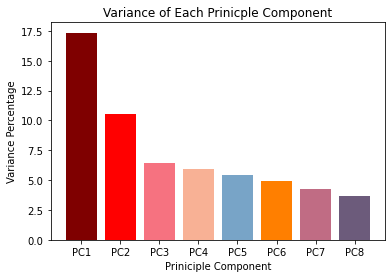

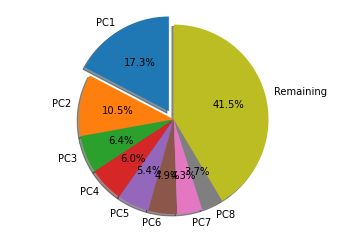

Variance Represented by PCA = 58.53 %


In [12]:
PCA=["PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8"]

COLORS =["#7f0000","#ff0000","#F67280","#F8B195", "#78a4c7","#ff7f00","#C06C84","#6C5B7B" ]

plt.bar(PCA, variance*100, color=COLORS)

plt.title('Variance of Each Prinicple Component')
plt.xlabel('Priniciple Component')
plt.ylabel('Variance Percentage')

# Pie chart
labels = "PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8", "Remaining"
sizes = [ variance[0], variance[1], variance[2], variance[3] , variance[4] ,variance[5],variance[6],variance[7] , 1 - ( variance[0] + variance[1] + variance[2] + variance[3] + variance[4] +variance[5]+variance[6]+variance[7]) ]
explode = (0.1, 0, 0, 0, 0, 0,0,0,0) 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, normalize=False)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()
print('Variance Represented by PCA = ' + str(round((variance[0] + variance[1] + variance[2] + variance[3] + variance[4]+variance[5]+variance[6]+variance[7])*100 , 2) ) +' %')

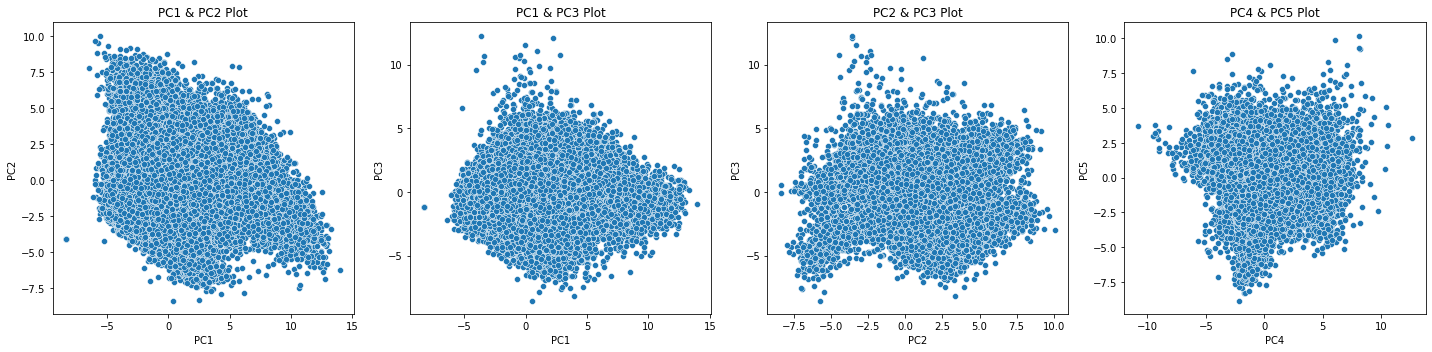

Text(0.5, 0.92, 'PCA 3D')

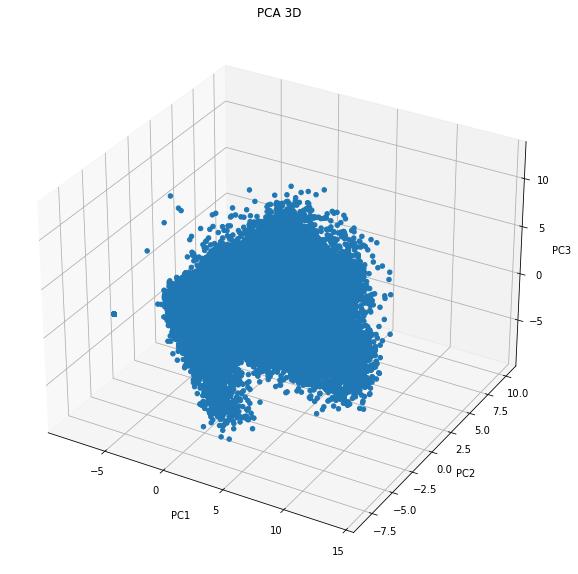

In [13]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
# sns.set(rc = {'figure.figsize':(15,8)})

sns.scatterplot(
    ax=axes[0],
    x="PC1", y="PC2",
    palette=sns.color_palette("icefire"),
    data=pca_df
)
axes[0].set_title("PC1 & PC2 Plot")
sns.scatterplot(
    ax=axes[1],
    x="PC1", y="PC3",
    palette=sns.color_palette("icefire"),
    data=pca_df
)
axes[1].set_title("PC1 & PC3 Plot")
sns.scatterplot(
    ax=axes[2],
    x="PC2", y="PC3",
    palette=sns.color_palette("icefire"),
    data=pca_df
)
axes[2].set_title("PC2 & PC3 Plot")

sns.scatterplot(
    ax=axes[3],
    x="PC4", y="PC5",
    palette=sns.color_palette("icefire"),
    data=pca_df
)
axes[3].set_title("PC4 & PC5 Plot")

plt.tight_layout()
plt.show()

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
scatter_3d = ax.scatter(
    xs=pca_df['PC1'], 
    ys=pca_df['PC2'], 
    zs=pca_df['PC3'], 
    alpha = 1
)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title("PCA 3D")

# TSNE

In [360]:
time_start = time.time()
tsne = opTSNE(
    n_components = 3,
    perplexity = 30,
    learning_rate = 200,
    initialization  = 'pca',
    random_state = 0,
    early_exaggeration = 12,
    n_iter = 1000,
    # verbose=False,
    early_exaggeration_iter = 250,
    # early_exaggeration = 10,
    # n_iter = 700,
    # initialization = 'pca',
    # initial_momentum = 0.5,
    # final_momentum = 0.8,
    metric="euclidean",
    # n_jobs=-1,
    # random_state=0,
    negative_gradient_method = 'barnes-hut',
    verbose=True,
)
%time tsne_results_op = tsne.fit(sample_only_scaled_data)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

# np.save('op_tSNE_Results_' + 'Time_{}_seconds'.format(time.time()-time_start) , tsne_results)

--------------------------------------------------------------------------------
TSNE(learning_rate=200, n_components=3, n_iter=1000,
     negative_gradient_method='barnes-hut', random_state=0, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 21.77 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 1.45 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.43 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 7.0109, 50 iterations in 63.2999 sec
Iteration  100, KL divergence 6.9883, 50 iterations in 62.3550 sec
Iteration  150, KL divergence 6.2681, 50 iterations in 59.5690 sec
Iteration  200, KL divergence 6.0870, 50 iterations in 55.1690 sec
Iteration  250, KL divergence 6.0547, 50 iterations in 55.9819 sec
   --> Time elap

In [14]:
# tsne_results_op = np.load('op_tSNE_Results_per30_lr200_earlyexagiter450_earlyexag10_iter700_intialization_PCATime_493.8574388027191_seconds.npy')
# tsne_results_op = np.load('op_tSNE_Results_per30_lr200_earlyexagiter250_earlyexag12_iter1000_PCATime_1808.5516831874847_seconds.npy')
tsne_results_op = np.load('tSNE_Breast_Results_default_Time_1533.5955548286438_seconds.npy')

In [81]:

np.save('op_tSNE_Results_per30_lr200_earlyexagiter250_earlyexag12_iter1000_PCA' + 'Time_{}_seconds'.format(time.time()-time_start) , tsne_results_op)

In [15]:
tsne_df = pd.DataFrame(data=tsne_results_op[:],columns=["tSNE_dim1","tSNE_dim2","tSNE_dim3"])
tsne_df['pixel_ID'] = sample_ID_pixels
tsne_df['L_Component'] = tsne_results_op[:,0]
tsne_df['A_Component'] = tsne_results_op[:,1]
tsne_df['B_Component'] = tsne_results_op[:,2]

In [16]:
LAB_mapping = [ tsne_df['L_Component'] , tsne_df['A_Component'] , tsne_df['B_Component'] ]
LAB_colors = np.asarray(LAB_mapping)
LAB_colors = LAB_colors.swapaxes(0,1)

L = rescale(LAB_colors[:,0]) * 100
A = rescale_AB(LAB_colors[:,1])
B = rescale_AB(LAB_colors[:,2])
LAB_colors = np.asarray( [ L , A, B ] )
LAB_colors = LAB_colors.swapaxes(0,1)
RGB_colors = lab2rgb(LAB_colors)

C:\Users\roaa\Anaconda3\lib\site-packages\skimage\color\colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 1726 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


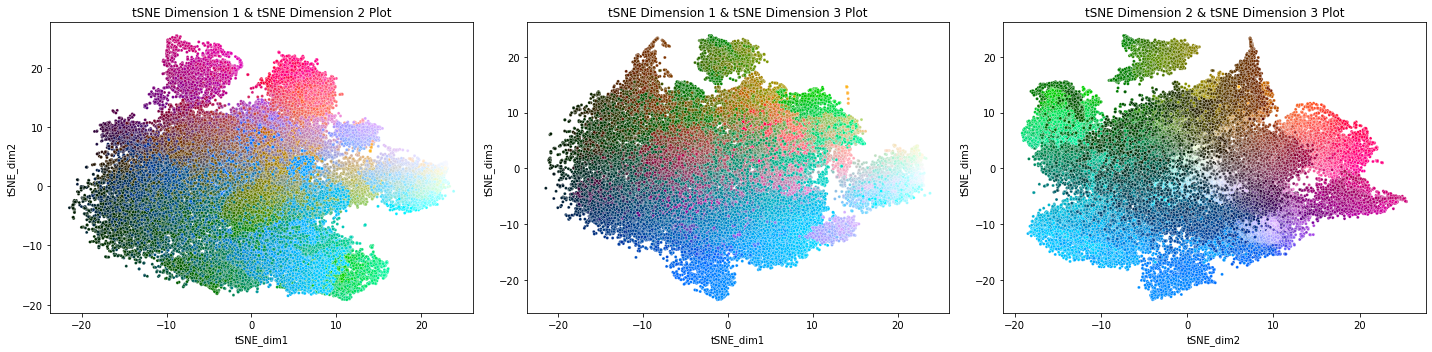

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
# sns.set(rc = {'figure.figsize':(15,8)})
marker_size = 9

sns.scatterplot(
    ax = axes[0],
    x = "tSNE_dim1", y="tSNE_dim2",
    c = RGB_colors,
    s = marker_size,
    data = tsne_df
)
axes[0].set_title("tSNE Dimension 1 & tSNE Dimension 2 Plot")

sns.scatterplot(
    ax = axes[1],
    x = "tSNE_dim1", y="tSNE_dim3",
    c = RGB_colors,
    s = marker_size,
    data = tsne_df
)
axes[1].set_title("tSNE Dimension 1 & tSNE Dimension 3 Plot")

sns.scatterplot(
    ax = axes[2],
    x = "tSNE_dim2", y="tSNE_dim3",
    c = RGB_colors,
    s = marker_size,
    data = tsne_df
)
axes[2].set_title("tSNE Dimension 2 & tSNE Dimension 3 Plot")



plt.tight_layout()
plt.show()


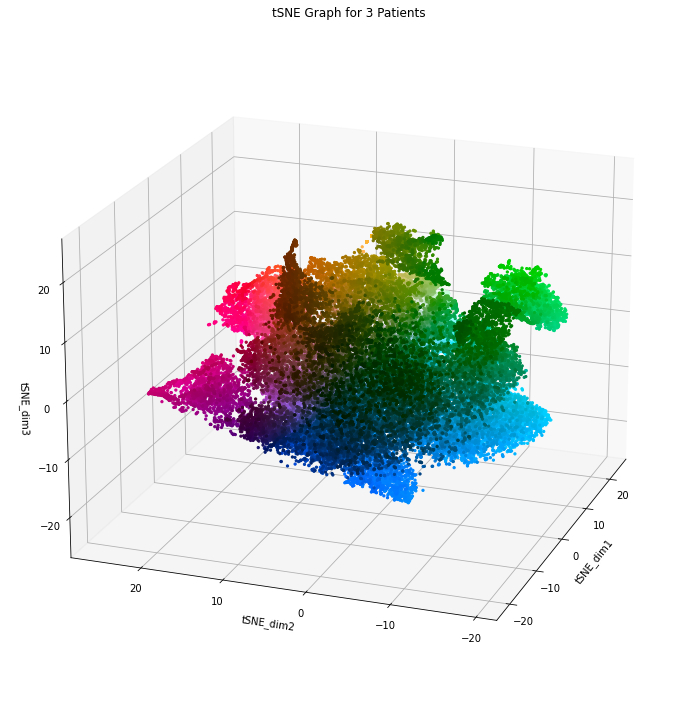

In [18]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
scatter_3d = ax.scatter(
    xs=tsne_df['tSNE_dim1'], 
    ys=tsne_df['tSNE_dim2'],
    zs= tsne_df['tSNE_dim3'],
    c = RGB_colors,
    s = 5,
    alpha = 1,
)
# ax.set_xlim(-40,40)
# ax.set_ylim(-40,40)
# ax.set_zlim(-40,40)
ax.set_xlabel('tSNE_dim1')
ax.set_ylabel('tSNE_dim2')
ax.set_zlabel('tSNE_dim3')
ax.set_title("tSNE Graph for 3 Patients")

fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# elev is z-axis, +ve moves up, -ve moves down
# azim is x axis, +ve moves right, -ve moves left
ax.view_init(elev = 20 , azim = -160) 
plt.tight_layout()


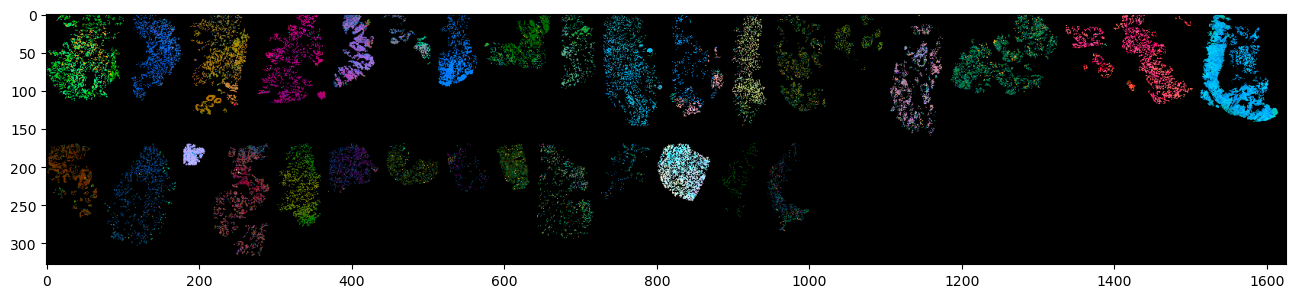

In [19]:
indices_edit = np.where(pixel_to_sample_ID != -1)
tsne_image = np.zeros( (height,width,3) )
increment = 0

for i,j in zip(indices_edit[0],indices_edit[1]):
    tsne_image[i][j][0] = RGB_colors[increment][0]
    tsne_image[i][j][1] = RGB_colors[increment][1]
    tsne_image[i][j][2] = RGB_colors[increment][2]
    increment += 1

plt.figure(figsize=(16, 8), dpi=100)
plt.imshow(tsne_image)


# Kmeans 

In [21]:
kmeans = KMeans(n_clusters=8, n_init=100, max_iter=2000, random_state=0, verbose=0 ).fit(tsne_results_op)
kmeans_7 = KMeans(n_clusters=7, n_init=100, max_iter=2000, random_state=0, verbose=0 ).fit(tsne_results_op)
kmeans_6 = KMeans(n_clusters=6, n_init=100, max_iter=2000, random_state=0, verbose=0 ).fit(tsne_results_op)



In [19]:
kmeans_9 = KMeans(n_clusters=9, n_init=100, max_iter=2000, random_state=0, verbose=0 ).fit(tsne_results_op)


In [22]:
indices_edit = np.where(pixel_to_sample_ID != -1)
KMeans_image = np.full( (height,width),-1 )
KMeans_image_6 = np.full( (height,width),-1 )
KMeans_image_7 = np.full( (height,width),-1 )

increment = 0
for i,j in zip(indices_edit[0],indices_edit[1]):
    KMeans_image[i][j] = kmeans.labels_[increment]
    
    increment += 1

increment = 0
for i,j in zip(indices_edit[0],indices_edit[1]):
    KMeans_image_6[i][j] = kmeans_6.labels_[increment]
    
    increment += 1
increment = 0
for i,j in zip(indices_edit[0],indices_edit[1]):
    KMeans_image_7[i][j] = kmeans_7.labels_[increment]
    
    increment += 1

# Gaussian Mixture Model

In [438]:
gmm = GaussianMixture(n_components=8, 
                         max_iter=1500, 
                         n_init=10, 
                      covariance_type='diag', verbose=0, random_state=42).fit_predict(tsne_results_op)


In [439]:
indices_edit = np.where(pixel_to_sample_ID != -1)
gaussian_image= np.full( (height,width),-1 )

increment = 0
for i,j in zip(indices_edit[0],indices_edit[1]):
    gaussian_image[i][j] = gmm[increment]
    

    increment += 1

# Bisecting kmeans

In [52]:
# Manual Implementation of Bisecting KMeans , need to add reference

from sklearn.utils import shuffle

def initialCentroids(matrix):
    matrixShuffled = shuffle(matrix, random_state=0)
    return matrixShuffled[:2,:]

def similarity(matrix, centroids):
    similarities = matrix.dot(centroids.T)
    return similarities
def findClusters(matrix, centroids):
    
    clusterA = list()
    clusterB = list()
    
    similarityMatrix = similarity(matrix, centroids)
    
    for index in range(similarityMatrix.shape[0]):
        similarityRow = similarityMatrix[index]
        
        #Sort the index of the matrix in ascending order of value and get the index of the last element
        #This index will be the cluster that the row in input matrix will belong to
        similaritySorted = np.argsort(similarityRow)[-1]
        if similaritySorted == 0:
            clusterA.append(index)
        else:
            clusterB.append(index)
        
    return clusterA, clusterB

def recalculateCentroid(matrix, clusters):
    centroids = list()
    
    for i in range(0,2):
        cluster = matrix[clusters[i],:]
        clusterMean = cluster.mean(0)
        centroids.append(clusterMean)
        
    centroids_array = np.asarray(centroids)
    
    return centroids_array

def calculateSSE(matrix, clusters):
    
    SSE_list = list()
    SSE_array = []
    
    for cluster in clusters:
        members = matrix[cluster,:]
        SSE = np.sum(np.square(members - np.mean(members)))
        SSE_list.append(SSE)
        
    SSE_array = np.asarray(SSE_list)
    dropClusterIndex = np.argsort(SSE_array)[-1]
            
    return dropClusterIndex

def kmeans(matrix, numberOfIterations):
    
    centroids = initialCentroids(matrix)
    
    for _ in range(numberOfIterations):
        
        clusters = list()
        
        clusterA, clusterB = findClusters(matrix, centroids)
        
        if len(clusterA) > 1:
            clusters.append(clusterA)
        if len(clusterB) > 1:
            clusters.append(clusterB)
            
        centroids = recalculateCentroid(matrix, clusters)
        
    return clusterA, clusterB



def bisecting_kmeans(matrix, k, numberOfIterations):
    
    clusters = list()
    
    initialcluster = list()
    for i in range(matrix.shape[0]):
        initialcluster.append(i)
    
    clusters.append(initialcluster)
    
    while len(clusters) < k:

        dropClusterIndex = calculateSSE(matrix, clusters)
        droppedCluster = clusters[dropClusterIndex]
        
        clusterA, clusterB = kmeans(matrix[droppedCluster,:], numberOfIterations)
        del clusters[dropClusterIndex]
        
        actualClusterA = list()
        actualClusterB = list()
        for index in clusterA:
            actualClusterA.append(droppedCluster[index])
            
        for index in clusterB:
            actualClusterB.append(droppedCluster[index])
        
        clusters.append(actualClusterA)
        clusters.append(actualClusterB)
    
    labels = [0] * matrix.shape[0]

    for index, cluster in enumerate(clusters):
        for idx in cluster:
            labels[idx] = index + 1
    return labels

In [54]:
bisecting_kmeans_labels = np.array(bisecting_kmeans(tsne_results_op , 8, 100) ) - 1


IndexError: list index out of range

In [51]:
indices_edit = np.where(pixel_to_sample_ID != -1)
bisecting_kmeans_image = np.full( (height,width),-1 )
increment = 0
for i,j in zip(indices_edit[0],indices_edit[1]):
    bisecting_kmeans_image[i][j] = bisecting_kmeans_labels[increment]
    increment += 1

NameError: name 'bisecting_kmeans_labels' is not defined

# Whole image Results

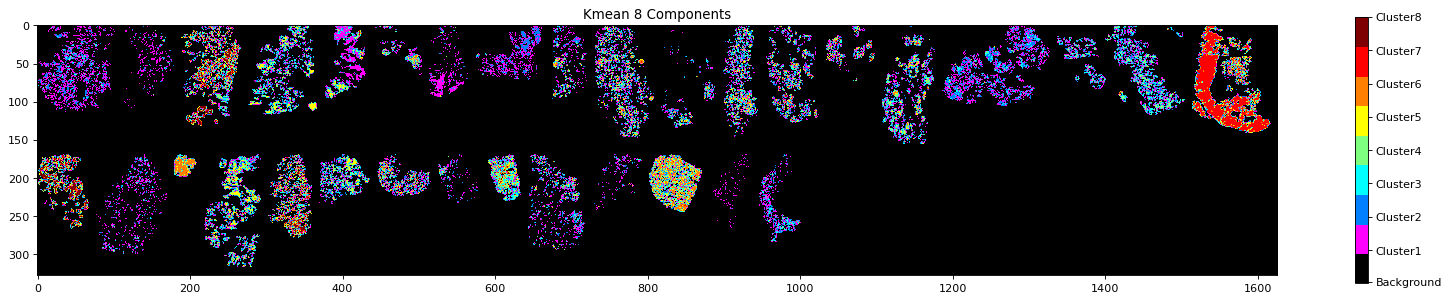

In [23]:
plt.figure(figsize=(25, 15), dpi=80)
plt.figure(1)
plt.subplot(311)
plt.title("Kmean 8 Components")
plt.imshow(KMeans_image, cmap=cmap8)
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 2 , 3 , 4,5,6,7,8])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3","Cluster4","Cluster5","Cluster6","Cluster7","Cluster8"])


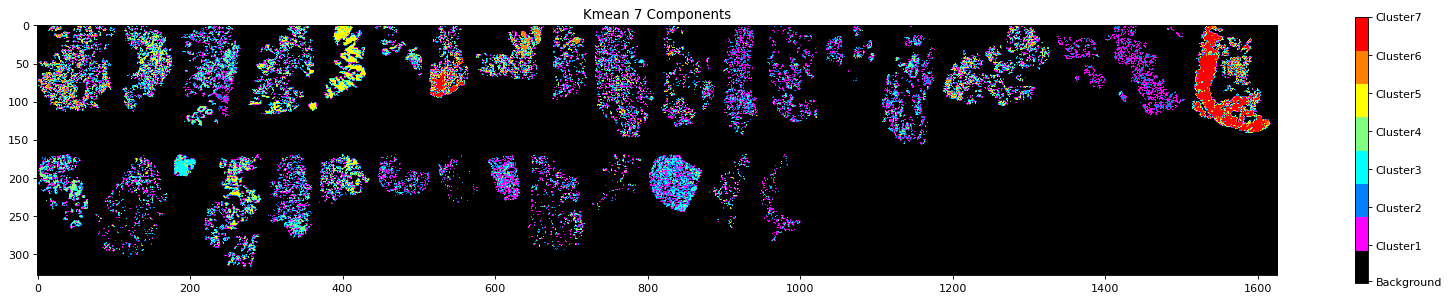

In [590]:
plt.figure(figsize=(25, 15), dpi=80)
plt.figure(1)
plt.subplot(311)
plt.title("Kmean 7 Components")
plt.imshow(KMeans_image_7, cmap=cmap7)
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 2 , 3 , 4,5,6,7])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3","Cluster4","Cluster5","Cluster6","Cluster7"])

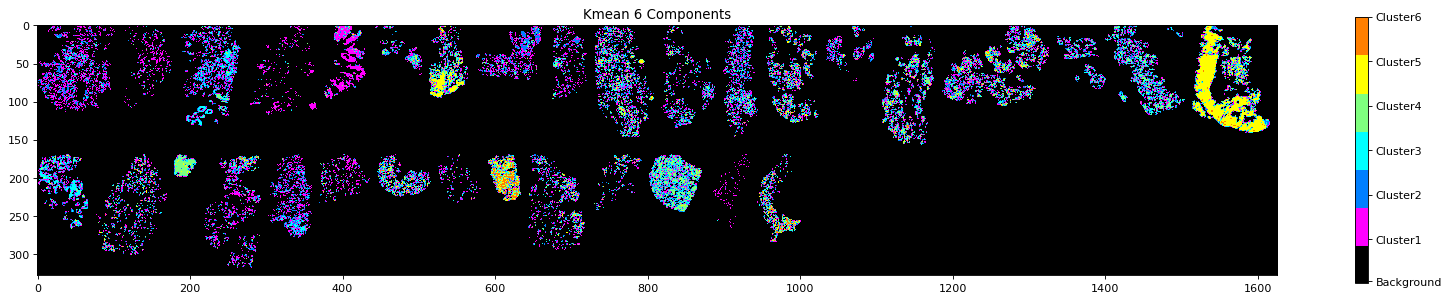

In [591]:
plt.figure(figsize=(25, 15), dpi=80)
plt.figure(1)
plt.subplot(311)
plt.title("Kmean 6 Components")
plt.imshow(KMeans_image_6, cmap=cmap6)
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 2 , 3 , 4,5])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3","Cluster4","Cluster5","Cluster6"])

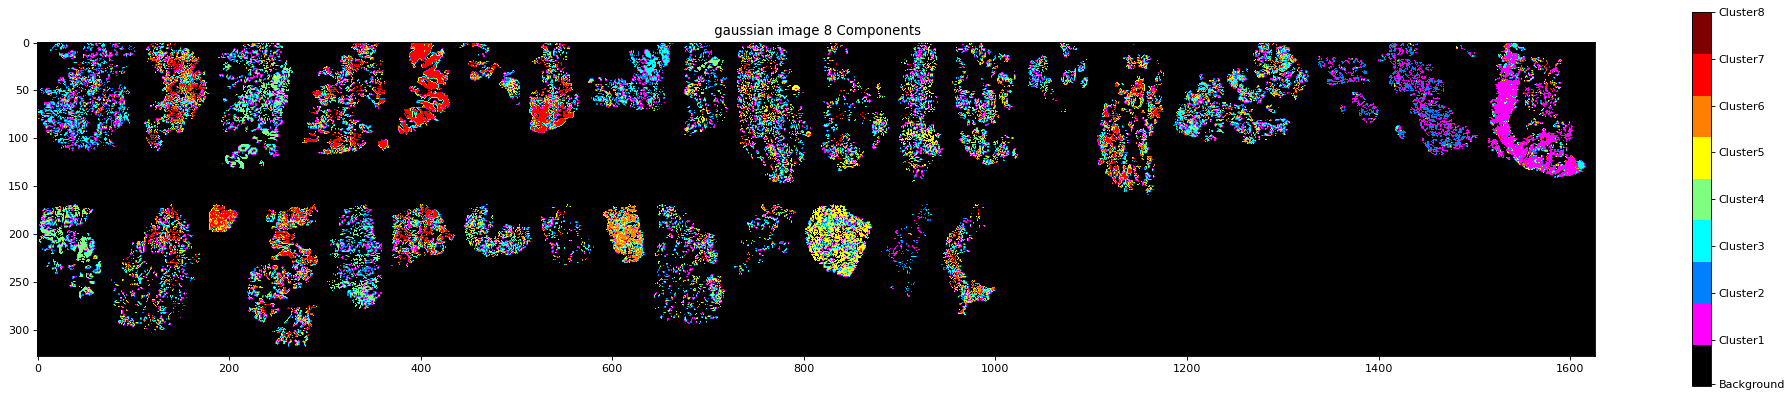

In [545]:
plt.figure(figsize=(25, 15), dpi=80)
plt.figure(1)
plt.subplot(311)
plt.title(" gaussian image 8 Components")
plt.imshow(gaussian_image, cmap=cmap)
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 2 , 3 , 4,5,6,7,8])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3", "Cluster4", "Cluster5", "Cluster6", "Cluster7", "Cluster8"])



plt.tight_layout()
plt.show()

In [61]:
# plt.figure(figsize=(25, 15), dpi=80)
# plt.figure(1)
# plt.subplot(311)
# plt.title("bisecting kmeans image 8 Components")
# plt.imshow(bisecting_kmeans_image, cmap=cmap)
# colorbar = plt.colorbar()
# colorbar.set_ticks([-0.95 , 0 , 1, 2 , 3 , 4,5,6,7,8])
# colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3", "Cluster4", "Cluster5", "Cluster6", "Cluster7", "Cluster8"])



# plt.tight_layout()
# plt.show()

# Zoomedin image Results

In [35]:
zoomed_height_max , zoomed_height_min , zoomed_width_max , zoomed_width_min = SampleZoomIn(SampleID = 5, PixelSampleID = pixel_to_sample_ID , padding_factor = 2)

zoomedIn_image= KMeans_image[zoomed_height_min : zoomed_height_max+1, zoomed_width_min : zoomed_width_max+1]
# zoomedIn_image_gmm= gaussian_image[zoomed_height_min : zoomed_height_max+1, zoomed_width_min : zoomed_width_max+1]
# zoomedIn_image_bisecting= bisecting_kmeans_image[zoomed_height_min : zoomed_height_max+1, zoomed_width_min : zoomed_width_max+1]

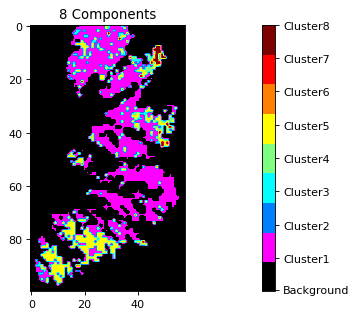

In [36]:
plt.figure(figsize=(25, 15), dpi=80)
plt.figure(1)
plt.subplot(311)
plt.title("8 Components")
plt.imshow(zoomedIn_image, cmap=cmap8)
colorbar = plt.colorbar()
colorbar.set_ticks([-0.95 , 0 , 1, 2 , 3 , 4,5,6,7,8])
colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3", "Cluster4", "Cluster5", "Cluster6", "Cluster7", "Cluster8"])

# plt.subplot(312)
# plt.title("8 Components")
# plt.imshow(zoomedIn_image_gmm, cmap=cmap)
# colorbar = plt.colorbar()
# colorbar.set_ticks([-0.95 , 0.1 , 1.1, 2.1 , 3.1 , 4.1,5.1,6.1,7.1,8.1])
# colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3", "Cluster4", "Cluster5", "Cluster6", "Cluster7", "Cluster8"])

# plt.subplot(313)
# plt.title("8 Components")
# plt.imshow(zoomedIn_image_bisecting, cmap=cmap)
# colorbar = plt.colorbar()
# colorbar.set_ticks([-0.95 , 0 , 1, 2 , 3 , 4,5,6,7,8])
# colorbar.set_ticklabels(["Background" , "Cluster1" , "Cluster2" , "Cluster3", "Cluster4", "Cluster5", "Cluster6", "Cluster7", "Cluster8"])
# plt.tight_layout()
# plt.show()

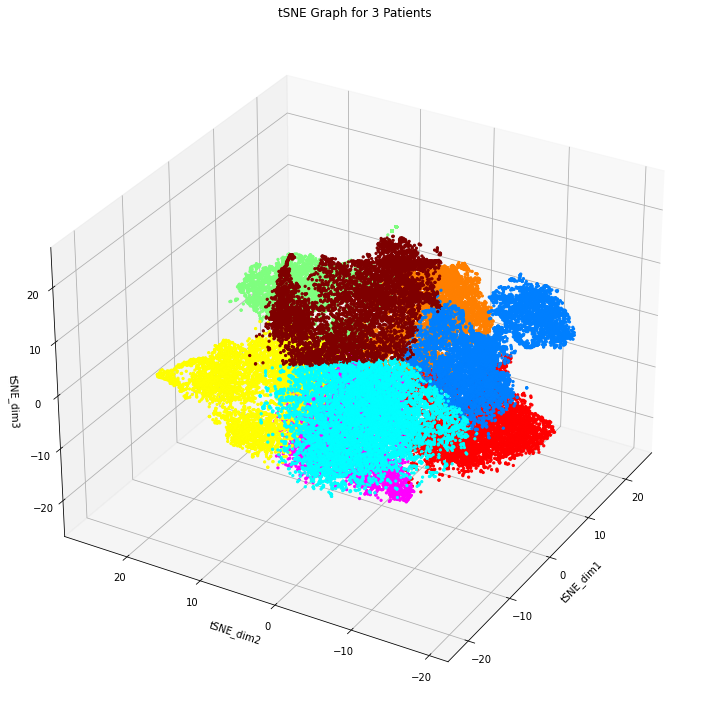

In [39]:
colors = ["#16235A","#F28A30","#888C46"]
# cmap = CreateColorMap(NumberofColors = 3 , colorsArray = colors)
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
scatter_3d = ax.scatter(
    xs=tsne_df['tSNE_dim1'], 
    ys=tsne_df['tSNE_dim2'], 
    zs=tsne_df['tSNE_dim3'], 
    c = kmeans.labels_,
    cmap = cmapTSNE,
    s = 5,
    alpha = 1,
)

ax.set_xlabel('tSNE_dim1')
ax.set_ylabel('tSNE_dim2')
ax.set_zlabel('tSNE_dim3')
ax.set_title("tSNE Graph for 3 Patients")

# fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# elev is z-axis, +ve moves up, -ve moves down
# azim is x axis, +ve moves right, -ve moves left
ax.view_init(elev = 30 , azim = -150) 
plt.tight_layout()

## Metastatis Analysis

In [20]:
Clinical_data = pd.read_excel('ClinicalData.xlsx',"Breast Cancer Clinical Data")
# print(Clinical_data["pN"])

In [22]:
def metastasis_status(labels,Clinical_data,colors=cmap8,sample_ID_pixels = sample_ID_pixels):
    
    Clinical_data_copied = Clinical_data.copy(deep=True)
    
    labels_count = len(np.unique(labels))
    Clusters = [ [] for _ in range(labels_count) ]

    for i in range(len(Clinical_data) ):
        Pixels_Samples = np.where(sample_ID_pixels == i)[0]
        Patient_Labels = labels[Pixels_Samples]

        for cluster_label in range(labels_count):
            Patient_Pixels = Patient_Labels[Patient_Labels == cluster_label]
            if len(Patient_Pixels) >= int( (1/labels_count * len(Patient_Labels))):
                Clusters[cluster_label].append(i)
    

    Belong_Clusters_0 = [ [] for _ in range(labels_count) ]
    Belong_Clusters_1 = [ [] for _ in range(labels_count) ]

    for i in range(1, len(Clinical_data)+1):
        for j in range(labels_count):
            if (i in Clusters[j]):
                if Clinical_data["pN"][i]==1:
                    Belong_Clusters_0[j].append(1)
                elif Clinical_data["pN"][i]==2:
                    Belong_Clusters_1[j].append(1)
    

    return Belong_Clusters_0,Belong_Clusters_1



In [23]:
def plot_metastasis_status(state0,state1):
   ind=len(state0)
   status0=np.zeros(ind)
   status1=np.zeros(ind)
   x=[]
   for i in range (1,ind+1):
      x.append(str(i))
   print(ind)
   print(status0.shape)
   # print(state0.?shape)
   for i in range (len(state0)):
      status0[i]=len(state0[i])
   for i in range (len(state1)):
      status1[i]=len(state1[i])
   print("Non metastasis"+ str(status0))
   print("metastasis"+ str(status1))



   plt.bar(x, status0,color="#d4d0c8" )
   plt.bar(x,status1 , bottom=status0,color="black")
   plt.xticks(x)
   plt.xlabel("Cluster number")
   plt.ylabel("Number of patients")
   colors = {'pN0':'#d4d0c8', 'pN1':'black'}         
   labels = list(colors.keys())
   handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
   plt.legend(handles, labels)

   plt.show()

9
(9,)
Non metastasis[4. 2. 1. 1. 5. 1. 2. 0. 2.]
metastasis[ 0.  3. 12.  1.  2.  8.  4.  6.  4.]


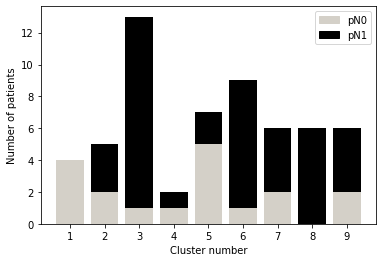

In [24]:
# state08,state18=metastasis_status(kmeans.labels_,Clinical_data)
# state07,state17=metastasis_status(kmeans_7.labels_,Clinical_data)
# # state06,state16=metastasis_status(kmeans_6.labels_,Clinical_data)
# gmm08,gmm18=metastasis_status(gmm,Clinical_data)
state09,state19=metastasis_status(kmeans_9.labels_,Clinical_data)
# plot_metastasis_status(state08,state18)
# plot_metastasis_status(state07,state17)
# plot_metastasis_status(state06,state16)
# plot_metastasis_status(gmm08,gmm18)
plot_metastasis_status(state09,state19)
